In [ ]:
!pip install -q transformers datasets tokenizers

     |████████████████████████████████| 3.1 MB 5.4 MB/s 
     |████████████████████████████████| 290 kB 49.4 MB/s 
     |████████████████████████████████| 3.3 MB 32.8 MB/s 
     |████████████████████████████████| 596 kB 44.8 MB/s 
     |████████████████████████████████| 895 kB 46.8 MB/s 
     |████████████████████████████████| 59 kB 6.3 MB/s 
     |████████████████████████████████| 132 kB 45.2 MB/s 
     |████████████████████████████████| 1.1 MB 35.7 MB/s 
     |████████████████████████████████| 243 kB 49.5 MB/s 
     |████████████████████████████████| 192 kB 48.1 MB/s 
     |████████████████████████████████| 271 kB 43.3 MB/s 
     |████████████████████████████████| 160 kB 44.5 MB/s 


# Домашнее задание. Transformers.

Привет! Это очередное домашнее задание, но теперь ты познакомишься с моделя трансформеров и с библиотекой `HuggingFace🤗`. В этом задании будет предложено решить с помощью модели `GPT2` простую задачу (анализ сентимента) и сделать небольшое исследование карт внимания. Приступим!

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker

import torch
import torch.nn as nn

from transformers import GPT2ForSequenceClassification, GPT2TokenizerFast, GPT2Config
from datasets import load_dataset

In [ ]:
device = "cuda" if torch.cuda.is_available else "cpu"

In [ ]:
!nvidia-smi

Thu Nov 18 19:09:38 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    73W / 149W |   7879MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Датасет, который мы будем использовать сегодня – тексты из английского твиттера. Они уже почищенны от никнеймов, знаков препинания и прочего. 

In [ ]:
emotion_dataset = load_dataset("emotion")

Downloading:   0%|          | 0.00/1.66k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.61k [00:00<?, ?B/s]

Using custom data configuration default


Downloading:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/204k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/207k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Посмотри, из чего состоит `emotion_dataset`:

In [ ]:
# emotion_dataset

In [ ]:
# emotion_dataset["train"]

In [ ]:
# emotion_dataset["train"]["text"][0]

In [ ]:
# emotion_dataset["train"]["label"][0]

In [ ]:
# len(emotion_dataset["train"])

Для перевода текста в токены мы будем использовать предобученный BPE-токенайзер.

In [ ]:
tokenizer = GPT2TokenizerFast.from_pretrained("distilgpt2")
tokenizer.pad_token = tokenizer.eos_token # У gpt2 нет pad токенов. Вместо них воспользуемся токенами конца текста.

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/762 [00:00<?, ?B/s]

Подготовь класс, который принимает датасет, токенайзер и имя используемой части (`train`, `validation`, `test`). Используй его для получения данных для обучения.

P.S. Посмотри, как работает токенайзер ([docs](https://huggingface.co/transformers/main_classes/tokenizer.html)) и подумай, как его надо добавить в датасет.

Немного примеров, как работает токенайзер. Это поможет с написанием датасета.

In [ ]:
# tokenizer.tokenize(emotion_dataset["train"]["text"][0])

In [ ]:
# tokenizer.encode(emotion_dataset["train"]["text"][0])

In [ ]:
# tokenizer.encode_plus(emotion_dataset["train"]["text"][0])

In [ ]:
# tokenizer.encode_plus(emotion_dataset["train"]["text"][0], return_tensors="pt")

In [ ]:
tokenizer.encode_plus(
    emotion_dataset["train"]["text"][0], 
    max_length=128, # максимальная длина текста
    padding="max_length", # надо ли добавлять паддинг в конце?
    return_tensors="pt", # возвращает pytorch тензоры
)

{'input_ids': tensor([[   72, 42547,  1254, 42659, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 5

In [ ]:
# Если надо, попрактикуйся работать с токенайзером здесь

In [ ]:
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, part, dataset=emotion_dataset, tokenizer=tokenizer, max_length=128):
        self.part = part
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length
        
        self.labels = np.unique(dataset[part]["label"])
        self.label2num = {l: num for num, l in enumerate(self.labels)}
        
    def __getitem__(self, idx):
        """
        Return dict with tokens, attention_mask and label
        """
        text = self.dataset[self.part]["text"][idx]
        label = self.dataset[self.part]["label"][idx]
        
        tokenizer_output = tokenizer.encode_plus(
            text,
            max_length=self.max_length,
            padding="max_length",
            return_tensors="pt")
        
        target = self.label2num[label]
        return {
            "input_ids": tokenizer_output['input_ids'].squeeze(0), 
            "mask": tokenizer_output['attention_mask'].squeeze(0),
            "target": target
        }
        
    def __len__(self):
        """
        Return length of dataset
        """
        return len(self.dataset[self.part])

Создай `train`, `validation` и `test` части датасета. Загрузи их в `DataLoaders`.

In [ ]:
train_dataset = TweetDataset(part='train')
valid_dataset = TweetDataset(part='validation')
test_dataset = TweetDataset(part='test')

In [ ]:
batch_size = 64 # Задай batch_size

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True  
)
valid_loader = torch.utils.data.DataLoader(
    dataset=valid_dataset, batch_size=batch_size, shuffle=False
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=batch_size, shuffle=False
)

In [ ]:
# batch = next(iter(train_loader))

## Начнем с нуля.

Попробуем обучить модель трансформер с нуля решать данную задачу.

In [ ]:
config = GPT2Config.from_pretrained(
    "distilgpt2", # distilgpt2 – уменьшенная версия модели gpt2
    output_attentions=True,
    pad_token_id=tokenizer.eos_token_id,
    num_labels=8
)
model_0 = GPT2ForSequenceClassification(config=config).to(device) # GPT2 для классификации текста

In [ ]:
print(torch.cuda.memory_allocated()/(1024**3)) # GB

0.31177806854248047


Подготовь оптимайзер и критерий:

In [ ]:
lr = 1e-5 # Предполагаемый learning rate. Он может быть больше или меньше :)

optimizer = torch.optim.Adam(params=model_0.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min') # Можно добавить шедулер для обучения моделей. Это на твое усмотрение

Посмотри, что возвращает модель ([docs](https://huggingface.co/transformers/model_doc/gpt2.html#gpt2forsequenceclassification)), если в неё подать данные:

In [ ]:
# tokens = batch['input_ids'].squeeze(1).to(device) # Получи токены из датасета
# mask = batch['mask'].squeeze(1).to(device) # Получи маску из датасета
# targets = batch['target'].to(device)

# output = model_0(input_ids=tokens, attention_mask=mask, labels=targets) # Посмотри на аутпут

Обучи модель с помощью `train_dataset`, проверяй во время обучения качество с помощью `valid_dataset` и получи финальное качество с помощью `test_dataset`.

In [ ]:
# for i in output:
#     if type(i) == type(()):
#         print(type(i))
#         for j in i:
#             print('\t', j.shape)
#     else:
#         print(i.shape)
#     print('\n')

In [ ]:
from tqdm.notebook import tqdm

num_epochs = 10
# Train loop
for e in range(num_epochs):
    model_0.train()
    train_loss = 0
    for batch in tqdm(train_loader):
        
        optimizer.zero_grad()
        
        target = batch['target'].to(device)
        input_ids = batch['input_ids'].to(device)
        mask = batch['mask'].to(device)
        
        output = model_0(input_ids = input_ids, attention_mask=mask)[0]
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
    valid_loss = 0
    valid_acc = 0
    model_0.eval()
    with torch.no_grad():
        for batch in valid_loader:
            
            target = batch['target'].to(device)
            input_ids = batch['input_ids'].to(device)
            mask = batch['mask'].to(device)
            
            output = model_0(input_ids = input_ids, attention_mask=mask)[0]
            _, predicted = torch.max(output, 1)
            
            valid_loss += criterion(output, target).item()
            valid_acc += (predicted == target).sum().item()/target.size(0)
        
    print(f"Train Loss: {train_loss / len(train_loader)},"
          f"Valid Loss: {valid_loss / len(valid_loader)},"
          f"Valid Acc: {valid_acc / len(valid_loader)}")
    last_val_acc = valid_acc / len(valid_loader)
# Testing
test_acc = 0
model_0.eval()
with torch.no_grad():
    for batch in test_loader:
        target = batch['target'].to(device)
        input_ids = batch['input_ids'].to(device)
        mask = batch['mask'].to(device)

        output = model_0(input_ids = input_ids, attention_mask=mask)[0]
        _, predicted = torch.max(output, 1)

        test_acc += (predicted == target).sum().item()/target.size(0)
        
print(f"Test Acc: {test_acc / len(test_loader)}")

  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 1.565573353767395,Valid Loss: 1.4440252035856247,Valid Acc: 0.4482421875


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 1.2540891132354737,Valid Loss: 1.0065159164369106,Valid Acc: 0.6328125


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.8541987810134888,Valid Loss: 0.7887308392673731,Valid Acc: 0.716796875


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.5755261546373367,Valid Loss: 0.6081901816651225,Valid Acc: 0.78564453125


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.3783727512955666,Valid Loss: 0.45430890936404467,Valid Acc: 0.85009765625


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.25980832481384275,Valid Loss: 0.40765014197677374,Valid Acc: 0.8662109375


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.19589882074296475,Valid Loss: 0.36088301287963986,Valid Acc: 0.88623046875


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.14180088427662849,Valid Loss: 0.3639836674556136,Valid Acc: 0.88623046875


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.11389157631993294,Valid Loss: 0.3518583399709314,Valid Acc: 0.89892578125


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.09038708810508252,Valid Loss: 0.3767792023718357,Valid Acc: 0.89453125
Test Acc: 0.888671875


После того, как получил лучшую модель для решения этой задачи, посмотри на карты внимания. Нашел ли что-нибудь интересное в них?

In [ ]:
def get_attention_matrixes(model, tokenizer, text, device=device):
    inp = list(filter(lambda x: x != tokenizer.sep_token_id, tokenizer.encode(text)))
    inp = torch.tensor(inp, dtype=torch.long, device=device).unsqueeze(0)
    attn_tensors = model(inp)[-1]
    seq = [tokenizer.decode(x) for x in inp[0].tolist()]
    attn = []
    for i in range(len(attn_tensors)):
        attn_layer = []
        for j in range(attn_tensors[i].size(1)):
            attn_layer.append(attn_tensors[i][0, j].cpu().detach().numpy())
        attn.append(np.array(attn_layer))
    
    return np.array(attn)

In [ ]:
def show_attention(seq, attentions):
    # Set up figure with colorbar
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions)
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels(['']+seq, rotation=90, fontsize=16)
    ax.set_yticklabels(['']+seq, fontsize=16)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [ ]:
def show_all_attentions(seq, all_attentions):
    num = 1
    n_layers = all_attentions.shape[0]
    n_heads = all_attentions.shape[1]
    
    fig = plt.figure(figsize=(20,10))
    
    for layer in range(n_layers):
        for head in range(n_heads):
            ax = fig.add_subplot(n_layers, n_heads, num)
            cax = ax.matshow(all_attentions[layer][head])
            num += 1
            
            plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False, labeltop=False)
            
    plt.show()

In [ ]:
text = emotion_dataset["train"]["text"][3] # Выбери текст из датасета
print(text)
tokens = tokenizer.tokenize(text)

i am ever feeling nostalgic about the fireplace i will know that it is still on the property


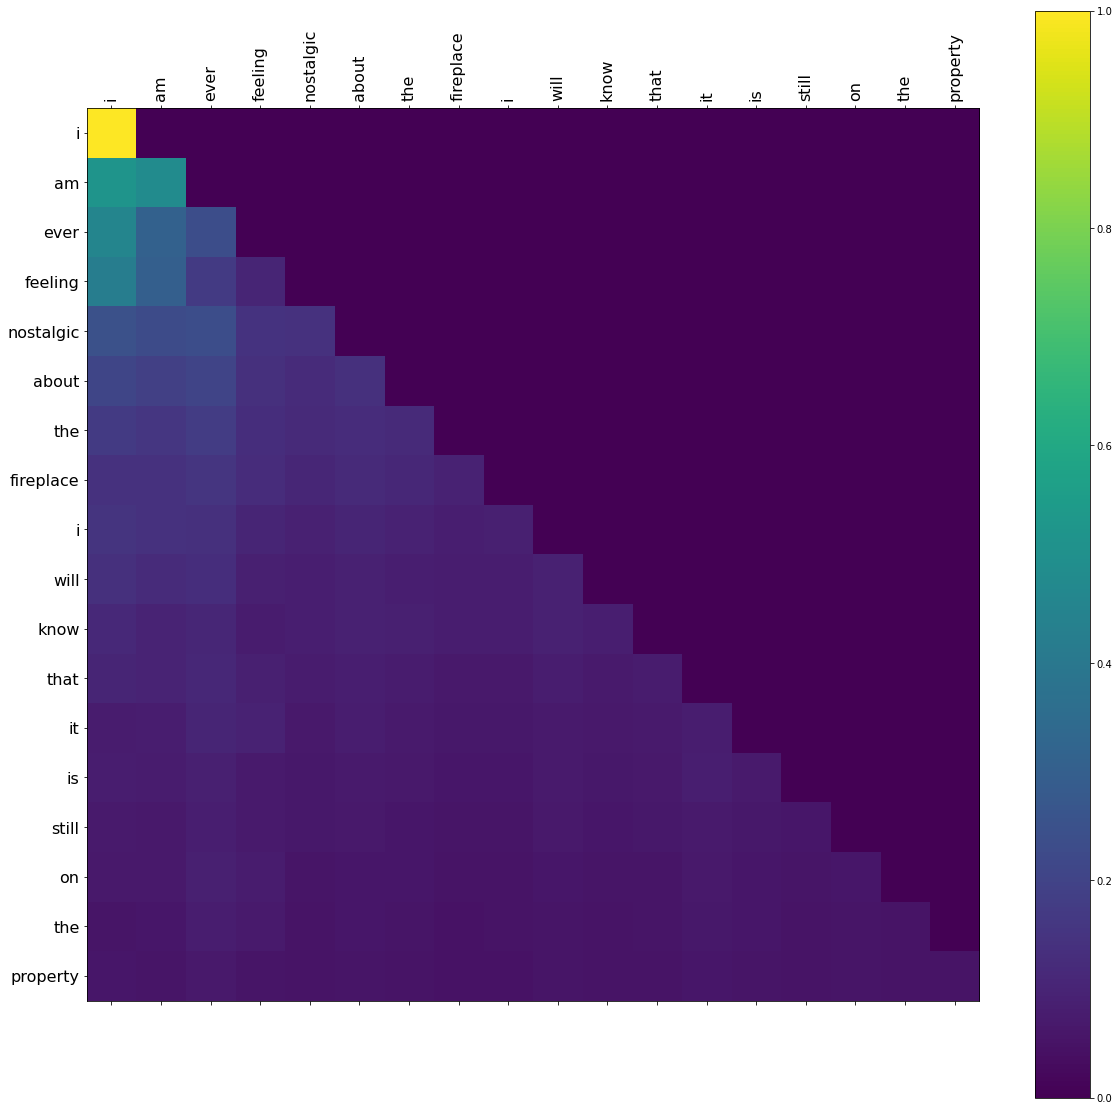

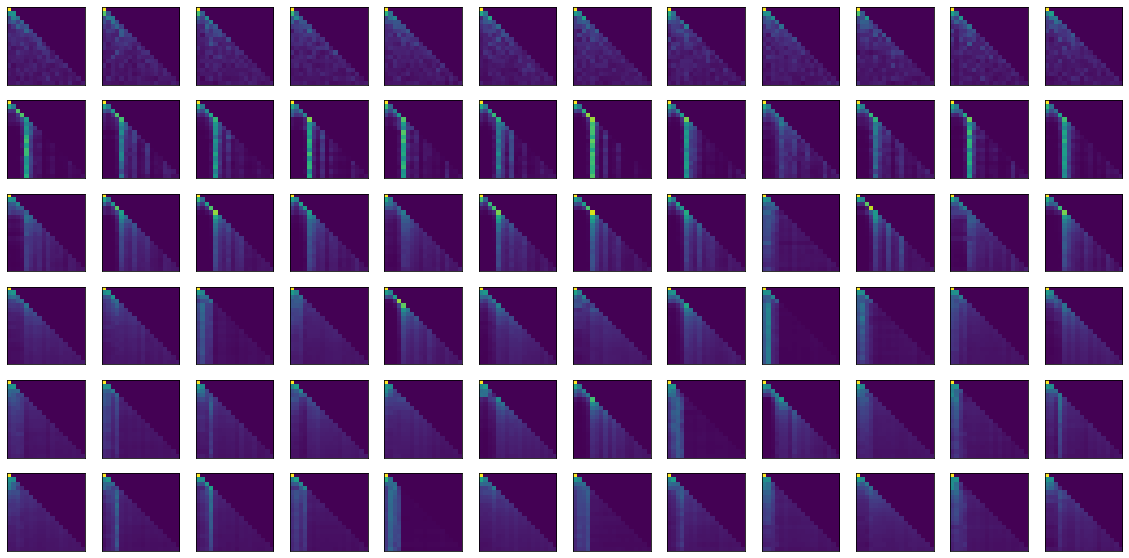

In [ ]:
attns = get_attention_matrixes(model_0, tokenizer, text)
show_attention(text.split(), attns[-1][0])
show_all_attentions(text.split(), attns)

## Fine-tuning

Теперь другой подход: загрузим модель, которая обучалась решать задачу Language Modeling. Посмотрим, получим ли мы прирост в качестве.

In [ ]:
model_1 = GPT2ForSequenceClassification.from_pretrained(
    "distilgpt2", 
    output_attentions=True,
    pad_token_id=tokenizer.eos_token_id,
    num_labels=8
).to(device)

Downloading:   0%|          | 0.00/336M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilgpt2 were not used when initializing GPT2ForSequenceClassification: ['lm_head.weight']
- This IS expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
lr = 1e-5 # Предполагаемый learning rate. Он может быть больше или меньше :)

optimizer = torch.optim.Adam(model_1.parameters(), lr)
criterion = nn.CrossEntropyLoss()

Вывод модели ничем не отличается от предыдущего случая, поэтому сразу приступаем к обучению:

In [ ]:
from tqdm.notebook import tqdm


num_epochs = 10

# Train loop
for e in range(num_epochs):
    model_1.train()
    train_loss = 0
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        
        target = batch['target'].to(device)
        input_ids = batch['input_ids'].to(device)
        mask = batch['mask'].to(device)
        
        output = model_1(input_ids = input_ids, attention_mask=mask)[0]
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
    valid_loss = 0
    valid_acc = 0
    model_1.eval()
    with torch.no_grad():
        for batch in valid_loader:
            target = batch['target'].to(device)
            input_ids = batch['input_ids'].to(device)
            mask = batch['mask'].to(device)
            
            output = model_1(input_ids = input_ids, attention_mask=mask)[0]
            _, predicted = torch.max(output, 1)
            
            valid_loss += criterion(output, target).item()
            valid_acc += (predicted == target).sum().item()/target.size(0)
            
    print(f"Train Loss: {train_loss / len(train_loader)},"
          f"Valid Loss: {valid_loss / len(valid_loader)},"
          f"Valid Acc: {valid_acc / len(valid_loader)}")
    last_val_acc = valid_acc / len(valid_loader)
    
# Testing
test_acc = 0
model_1.eval()
with torch.no_grad():
    for batch in test_loader:
        ...
print(f"Test Acc: {test_acc / len(test_loader)}")

  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 1.7018912048339845,Valid Loss: 1.0935423951596022,Valid Acc: 0.6103515625


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.7352602087259292,Valid Loss: 0.37876210920512676,Valid Acc: 0.8740234375


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.38184626775979996,Valid Loss: 0.24705493333749473,Valid Acc: 0.90576171875


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.26099159714579584,Valid Loss: 0.19644152955152094,Valid Acc: 0.91845703125


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.21002915820479393,Valid Loss: 0.1749676022445783,Valid Acc: 0.927734375


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.17822301495075227,Valid Loss: 0.16876422439236194,Valid Acc: 0.9248046875


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.15859152076393365,Valid Loss: 0.15612446295563132,Valid Acc: 0.931640625


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.14305389094352722,Valid Loss: 0.14833203796297312,Valid Acc: 0.9306640625


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.1290836827531457,Valid Loss: 0.14568095048889518,Valid Acc: 0.9296875


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.11999589782208205,Valid Loss: 0.14099893579259515,Valid Acc: 0.92822265625
Test Acc: 0.0


Есть ли прирост качества или скорости обучения?

Посмотри на карты внимания. Есть ли отличие от предыдущего случая?

In [ ]:
text = emotion_dataset["train"]["text"][3] # Выбери текст из датасета
print(text)
tokens = tokenizer.tokenize(text)

i am ever feeling nostalgic about the fireplace i will know that it is still on the property


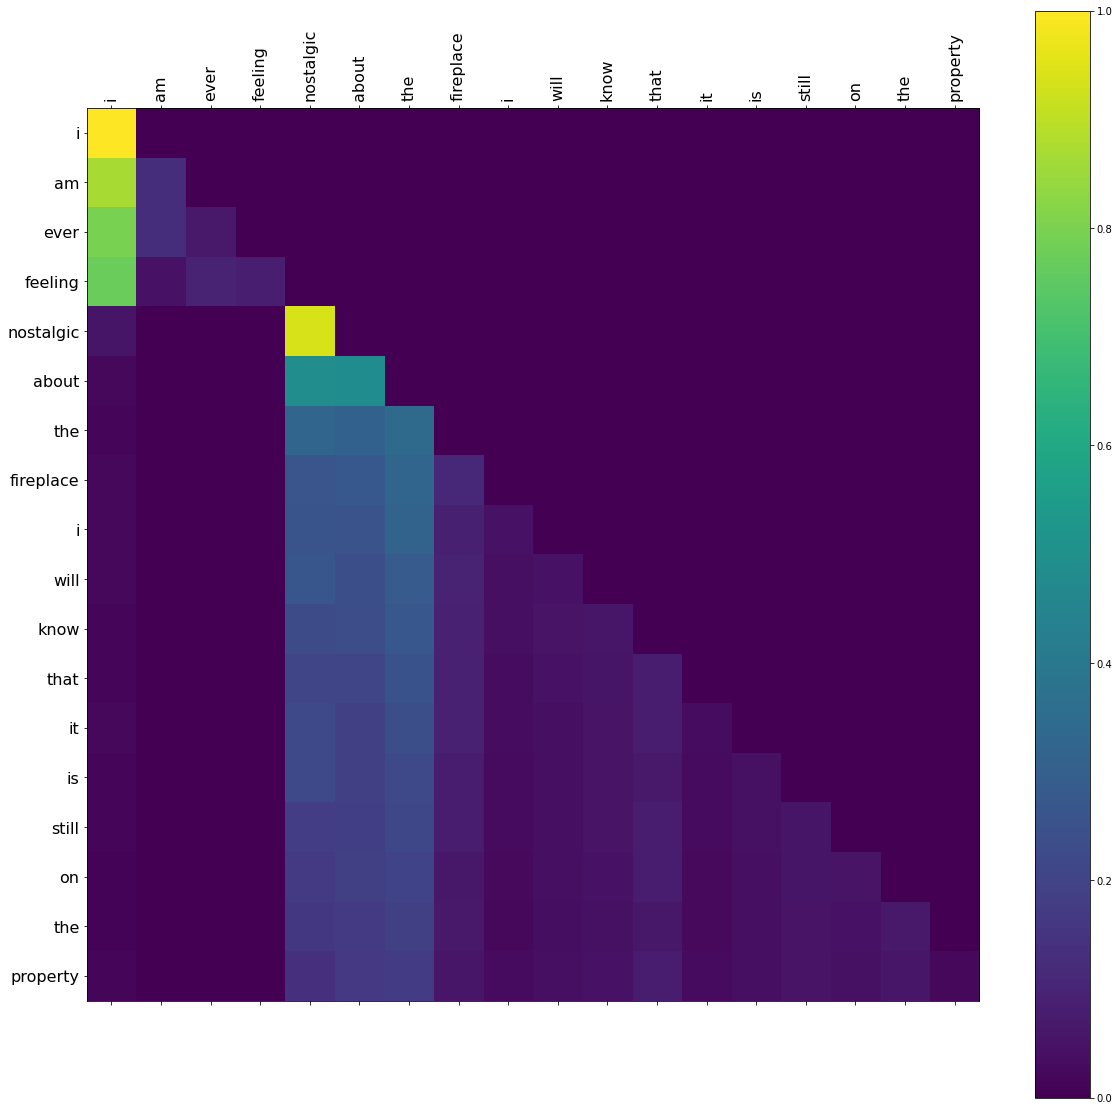

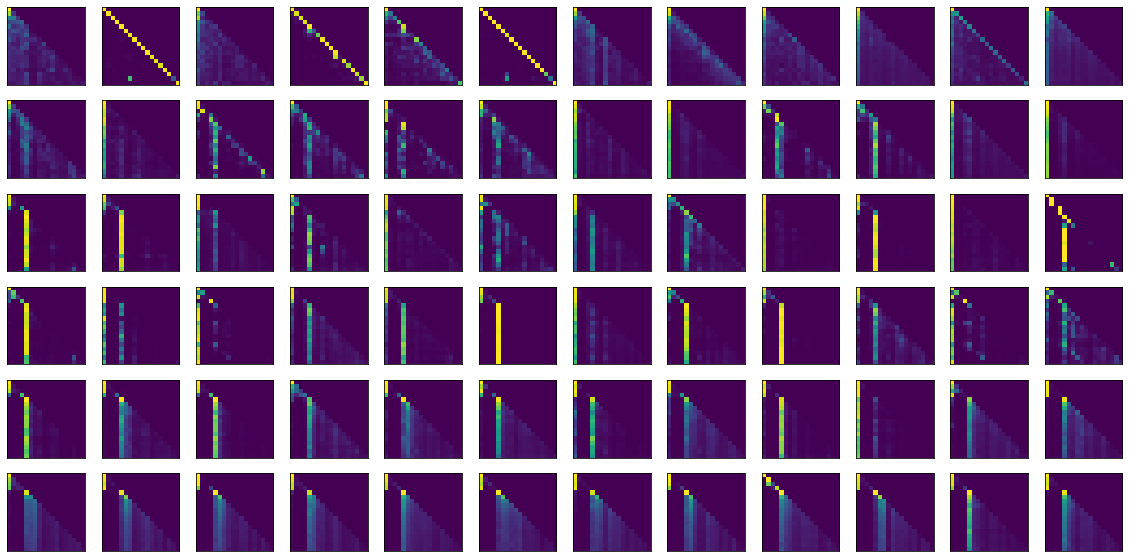

In [ ]:
attns = get_attention_matrixes(model_1, tokenizer, text)
show_attention(text.split(), attns[-1][0])
show_all_attentions(text.split(), attns)

## Отчет

Покажи здесь, что ты выполнил по этой работе. Ответь на несколько вопросов:
- Какой подход оказался лучше?   
Предобученная модель показала качество лучше (0.92 vs 0.89) и получалось это качество быстрее (6 vs 10 эпох)
- На какие слова модель большего всего обращала внимание?   
Обе модели смотрели примерно на одинаковые слова, но предобученная модель лучше замечала смысловую связь между словами. Так же у второй модели есть головы, которые смотрят просто на предыдущее слово.
- На каких слоях/головах модель обращала внимание?  
На всех слоях видно влияние других слов на слово(тавтология какая-то)
